In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from calendar import monthrange
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sales_monthly_wide = pd.read_pickle("data/processed/sales_monthly_wide_full.pickle")

In [2]:
sales_monthly_wide

,shop_id,item_id,item_category_id,item_category_1,item_category_2,shop_city,shop_category,item_cnt_month_0,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,item_cnt_month_4,item_cnt_month_5,item_cnt_month_6,item_cnt_month_7,item_cnt_month_8,item_cnt_month_9,item_cnt_month_10,item_cnt_month_11,item_cnt_month_12,item_cnt_month_13,item_cnt_month_14,item_cnt_month_15,item_cnt_month_16,item_cnt_month_17,item_cnt_month_18,item_cnt_month_19,item_cnt_month_20,item_cnt_month_21,item_cnt_month_22,item_cnt_month_23,item_cnt_month_24,item_cnt_month_25,item_cnt_month_26,item_cnt_month_27,item_cnt_month_28,item_cnt_month_29,item_cnt_month_30,item_cnt_month_31,item_cnt_month_32,item_cnt_month_33,min_item_cnt_month_0,min_item_cnt_month_1,min_item_cnt_month_2,min_item_cnt_month_3,min_item_cnt_month_4,min_item_cnt_month_5,min_item_cnt_month_6,min_item_cnt_month_7,min_item_cnt_month_8,min_item_cnt_month_9,min_item_cnt_month_10,min_item_cnt_month_11,min_item_cnt_month_12,min_item_cnt_month_13,min_item_cnt_month_14,min_item_cnt_month_15,min_item_cnt_month_16,min_item_cnt_month_17,min_item_cnt_month_18,min_item_cnt_month_19,min_item_cnt_month_20,min_item_cnt_month_21,min_item_cnt_month_22,min_item_cnt_month_23,min_item_cnt_month_24,min_item_cnt_month_25,min_item_cnt_month_26,min_item_cnt_month_27,min_item_cnt_month_28,min_item_cnt_month_29,min_item_cnt_month_30,min_item_cnt_month_31,min_item_cnt_month_32,min_item_cnt_month_33,max_item_cnt_month_0,max_item_cnt_month_1,max_item_cnt_month_2,max_item_cnt_month_3,max_item_cnt_month_4,max_item_cnt_month_5,max_item_cnt_month_6,max_item_cnt_month_7,max_item_cnt_month_8,max_item_cnt_month_9,max_item_cnt_month_10,max_item_cnt_month_11,max_item_cnt_month_12,max_item_cnt_month_13,max_item_cnt_month_14,max_item_cnt_month_15,max_item_cnt_month_16,max_item_cnt_month_17,max_item_cnt_month_18,max_item_cnt_month_19,max_item_cnt_month_20,max_item_cnt_month_21,max_item_cnt_month_22,max_item_cnt_month_23,max_item_cnt_month_24,max_item_cnt_month_25,max_item_cnt_month_26,max_item_cnt_month_27,max_item_cnt_month_28,max_item_cnt_month_29,max_item_cnt_month_30,max_item_cnt_month_31,max_item_cnt_month_32,max_item_cnt_month_33,min_date_0,min_date_1,min_date_2,min_date_3,min_date_4,min_date_5,min_date_6,min_date_7,min_date_8,min_date_9,min_date_10,min_date_11,min_date_12,min_date_13,min_date_14,min_date_15,min_date_16,min_date_17,min_date_18,min_date_19,min_date_20,min_date_21,min_date_22,min_date_23,min_date_24,min_date_25,min_date_26,min_date_27,min_date_28,min_date_29,min_date_30,min_date_31,min_date_32,min_date_33,max_date_0,max_date_1,max_date_2,max_date_3,max_date_4,max_date_5,max_date_6,max_date_7,max_date_8,max_date_9,max_date_10,max_date_11,max_date_12,max_date_13,max_date_14,max_date_15,max_date_16,max_date_17,max_date_18,max_date_19,max_date_20,max_date_21,max_date_22,max_date_23,max_date_24,max_date_25,max_date_26,max_date_27,max_date_28,max_date_29,max_date_30,max_date_31,max_date_32,max_date_33,count_date_0,count_date_1,count_date_2,count_date_3,count_date_4,count_date_5,count_date_6,count_date_7,count_date_8,count_date_9,count_date_10,count_date_11,count_date_12,count_date_13,count_date_14,count_date_15,count_date_16,count_date_17,count_date_18,count_date_19,count_date_20,count_date_21,count_date_22,count_date_23,count_date_24,count_date_25,count_date_26,count_date_27,count_date_28,count_date_29,count_date_30,count_date_31,count_date_32,count_date_33,mean_item_price_0,mean_item_price_1,mean_item_price_2,mean_item_price_3,mean_item_price_4,mean_item_price_5,mean_item_price_6,mean_item_price_7,mean_item_price_8,mean_item_price_9,mean_item_price_10,mean_item_price_11,mean_item_price_12,mean_item_price_13,mean_item_price_14,mean_item_price_15,mean_item_price_16,mean_item_price_17,mean_item_price_18,mean_item_price_19,mean_item_price_20,mean_item_price_21,mean_item_price_22,mean_item_price_23,mean_item_price_24,mean_item_price_25,mean_item_price_26,mean_item_price_27,mean_item_price_28,mean_item_price_29,mean_item_

In [3]:
def get_train_set_for_month(month, n, X_only=False):
    cols = list(sales_monthly_wide.columns)
    
    train_cols = ["shop_id", "item_id", "item_category_id", "item_category_1",
                  "item_category_2", "shop_city", "shop_category"]
    cols = cols[7:]
    
    train_cols += [c for c in cols if (
        int(c.split("_")[-1]) < month and
        int(c.split("_")[-1]) > month - n
    )]
    X = sales_monthly_wide[train_cols]
    if not X_only:
        y = sales_monthly_wide[[f"item_cnt_month_{month}"]]
        return X.values, y.values.reshape(-1), train_cols

    return X.values, train_cols

# small test
#get_train_set_for_month(33, 13, X_only=False)

In [4]:
import numpy as np

def clip(array):
    return np.array([max(min(x, 20), 0) for x in array])

clip(np.array([1, 2, 34, 45, 45, -111]))

array([ 1,  2, 20, 20, 20,  0])

In [5]:
%%time

from sklearn.model_selection import train_test_split

# create train and test set
n = 13
for i, month in tqdm(enumerate([33, 32, 31])):
    if i == 0:
        X, y, cols = get_train_set_for_month(month, n)
        continue
    
    X_inc, y_inc, _ = get_train_set_for_month(month, n)
    X = np.concatenate((X, X_inc), axis=0)
    y = np.concatenate((y, y_inc), axis=0)
    
    del X_inc, y_inc
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

0it [00:00, ?it/s]

CPU times: user 1min 3s, sys: 6.05 s, total: 1min 9s
Wall time: 1min 12s


In [6]:
X_train, cols

(array([[30, 6238, 55, ..., 30, 31, 31],
        [42, 19578, 40, ..., 31, 31, 30],
        [48, 16843, 61, ..., 31, 30, 31],
        ...,
        [18, 2293, 28, ..., 31, 31, 30],
        [19, 4242, 23, ..., 30, 31, 31],
        [16, 14879, 37, ..., 31, 31, 30]], dtype=object),
 ['shop_id',
  'item_id',
  'item_category_id',
  'item_category_1',
  'item_category_2',
  'shop_city',
  'shop_category',
  'item_cnt_month_21',
  'item_cnt_month_22',
  'item_cnt_month_23',
  'item_cnt_month_24',
  'item_cnt_month_25',
  'item_cnt_month_26',
  'item_cnt_month_27',
  'item_cnt_month_28',
  'item_cnt_month_29',
  'item_cnt_month_30',
  'item_cnt_month_31',
  'item_cnt_month_32',
  'min_item_cnt_month_21',
  'min_item_cnt_month_22',
  'min_item_cnt_month_23',
  'min_item_cnt_month_24',
  'min_item_cnt_month_25',
  'min_item_cnt_month_26',
  'min_item_cnt_month_27',
  'min_item_cnt_month_28',
  'min_item_cnt_month_29',
  'min_item_cnt_month_30',
  'min_item_cnt_month_31',
  'min_item_cnt_month_32'

In [7]:
%%time

"""
Random Forest for benchmark

0.5908137620659543
0.5873602753750339
CPU times: user 13min 5s, sys: 412 ms, total: 13min 5s
Wall time: 6min 44s
"""
from sklearn.metrics import mean_squared_error

rerun_rf = False

if rerun_rf:
    from sklearn.ensemble import RandomForestRegressor

    rf = RandomForestRegressor(
        n_estimators = 20,
        max_depth=10,
        min_samples_leaf=100,
        n_jobs=2,  # -1 is all processors used
    )


    rf.fit(X_train, clip(y_train))

    print(mean_squared_error(y_true=clip(y_train), y_pred=clip(rf.predict(X_train)), squared=False))
    print(mean_squared_error(y_true=clip(y_test), y_pred=clip(rf.predict(X_test)), squared=False))

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 15.7 µs


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [38]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

In [39]:
model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 151)               303       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                9728      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 14,256
Trainable params: 13,953
Non-trainable params: 303
_________________________________________________________________


In [42]:
history = model.fit(
    X_train.astype('float'), clip(y_train.astype('float')),
    validation_split=0.2,
    verbose=1, epochs=3)

Epoch 1/3
26478/26478 [==============================] - 46s 2ms/step - loss: 0.3520 - val_loss: 0.3804
Epoch 2/3
26478/26478 [==============================] - 51s 2ms/step - loss: 0.3497 - val_loss: 0.3781
Epoch 3/3
26478/26478 [==============================] - 52s 2ms/step - loss: 0.3474 - val_loss: 0.3810


In [45]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

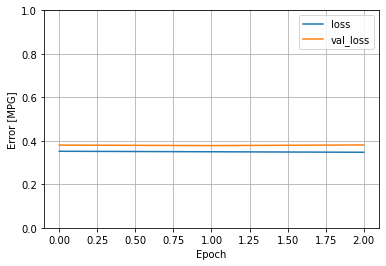

In [46]:
plot_loss(history)

In [47]:
print(mean_squared_error(y_true=clip(y_train), y_pred=clip(model.predict(X_train.astype("float"))), squared=False))
print(mean_squared_error(y_true=clip(y_test), y_pred=clip(model.predict(X_test.astype("float"))), squared=False))

<ipython-input-4-a316e8eee50f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([max(min(x, 20), 0) for x in array])


0.5896314635364875
0.5935136149634053


<ipython-input-4-a316e8eee50f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([max(min(x, 20), 0) for x in array])
